In [1]:
import pickle
import math
import random
import tldextract
import os

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

from joblib import Parallel, delayed

'''
randomWalk(graph, initial_node, step, max_step, path)

Function to take a random walk from a given node

graph: networkx graph, graph from which to random through
initial node: string, initial node to begin the walk
step: int, current step of walk
max_step: int, maximum number of steps to take in walk
path:, list, current path taken in the walk
'''
def randomWalk(graph, initial_node, step, max_step, path):
 
    if step>= max_step: 
        return path
    
    adjacent_nodes = [i for i in graph[initial_node]]
    #Weights here are normalized with respect to global max as opposed to local max!
    #Therefore have to reweight

    if len(adjacent_nodes) == 0:
        path.append(None)
        return path
    
    node_paths = graph[initial_node]
    adjacent_nodes_weights = [node_paths[i]['weight'] for i in node_paths]
    sum_weights = sum(adjacent_nodes_weights)
    adjacent_nodes_weights = [i/sum_weights for i in adjacent_nodes_weights]
    #print (adjacent_nodes_weights)

    #print (adjacent_nodes, adjacent_nodes_weights)
       
    next_node = np.random.choice(adjacent_nodes, p=adjacent_nodes_weights)
    
    path.append(next_node)
    
    return randomWalk(graph, next_node, step+1, max_step, path)

'''
generateBatch(batch_size, num_context_per_label, context_window, target, step)

batch_size: int, batch size for training
num_context_per_label: int, how many context examples to use per label (the label is the target) 
can't be greater than the context window size
context_window: int, size of the context window 
target: array, the list of targets for each context window
step: int, counter for how many times to step through the same context and target data

Generate the batch data for training. For each "context window", randomly sample a
set of context elements and configure them as training data by constructing column data of,

[target_0, context_0]
[target_0, context_1]
[target_0, context_3]
...
[target_n, context_3]
[target_n, context_2]
[target_n, context_1]

'''
def generateBatch(batch_size, num_context_per_label, context_window, target, step):

    batch = []
    passes_through_batch = batch_size//num_context_per_label
    for window_idx in range(passes_through_batch):
        
        current_window = list(context_window[window_idx + passes_through_batch*step])
        current_target = target[window_idx + passes_through_batch*step]
        context_samples = -1
        while context_samples == -1:
            
            context_samples = random.sample(current_window, num_context_per_label)
        
        data_samples =  [[context_sample, [current_target]] for context_sample in context_samples]

        for data_sample in data_samples:
            batch.append(data_sample)
            
    return batch

black_list = ['@', ':///', 'onlinecasinoreports']

In [2]:


def walkGraph(web_graph, node, step, max_step, current_path):
    
    path = randomWalk(web_graph, node, 0, max_step, current_path)

    path = [domain_map[i] for i in path]
    
    while len(path)-1!=max_step:
        path.append(None)
        
    return path

In [3]:
df_sp500 = pd.read_csv('sp500_links.csv')

In [6]:
#Figure out what blanks are!
#Create a graph out of the connections
edge_entries = {}
domain_graph = True
nodes_only = []
web_graph = nx.DiGraph()
#web_graph = nx.Graph()

In [7]:
domain_graph = True

In [8]:
'''
Fill a graph

[DOCUMENTATION NEEDED]

'''

def fillGraph(web_graph, graph_file, edge_entries, nodes_only, domain_graph=True):
    
    for node in graph_file.keys():
        if domain_graph:
            domain_node = tldextract.extract(node)
            domain_node = domain_node.domain
        else:
            domain_node = node

        domain_node = domain_node.lower()

        for idx in range(0, len(graph_file[node]), 3):
            key = graph_file[node][idx]

            if domain_graph:
                domain_key = tldextract.extract(key)
                domain_key = domain_key.domain
            else:
                domain_key = key

            if domain_node == domain_key: 
                continue        

            if domain_node is None or domain_key is None: 
                continue

            if True in [i in domain_node for i in black_list] or True in [i in domain_key for i in black_list]:
                continue

            domain_key = domain_key.lower()

            edge_connection = domain_node + '--' + domain_key
            if edge_connection not in edge_entries.keys():
                edge_entries[edge_connection]=1
            else:
                edge_entries[edge_connection]+=1

            weight = edge_entries[edge_connection]

            web_graph.add_weighted_edges_from([(domain_node, domain_key, weight)])

            nodes_only.append(domain_node)
    
    return web_graph

In [9]:
for idx, file in enumerate(os.listdir('./crawler_results/')):
    
    if 'final' not in file: 
        continue

    graph_file = pickle.load(open('./crawler_results/' + file, 'rb'))

    if len(web_graph.nodes())==0:
        directed_graph = fillGraph(web_graph, graph_file, edge_entries, nodes_only, domain_graph)
    else:
        directed_graph = fillGraph(directed_graph, graph_file, edge_entries, nodes_only, domain_graph)

graph_file = []

In [10]:
#edges = weights_list[0]
#weights = weights_list[1]/np.max(weights[1])#

In [11]:
list_of_nodes = [i for i in web_graph.nodes()]

domain_inv_map = {idx:i for idx, i in enumerate(list_of_nodes)}
domain_map = {i:idx for idx, i in enumerate(list_of_nodes)}
domain_map[None] = -1

In [13]:
no_next_neighbors = []
no_neighbors = []
for node in list_of_nodes:
    
    neighbors = [i for i in web_graph.neighbors(node)]
    for neighbor in neighbors:
        next_neighbors = [i for i in web_graph.neighbors(neighbor)]    
    
    try:
        next_neighbor_counts = [len(i) for i in next_neighbors]
    except:
        next_neighbor_counts = [0]
        
    if sum(next_neighbor_counts)==0:
        no_next_neighbors.append(node)
        
    if len(neighbors)==0:
        no_neighbors.append(node)    

In [14]:
nodes_only = list(set(nodes_only))

In [15]:
#Sanity check
#print('%d nodes, %d dict terms, %d key_domain dict' % (len(list_of_nodes), len(vocab_dict), len(key_domain_dict)))
print('%d nodes, %d key_domain dict, %d key_nodes only' % (len(list_of_nodes), len(domain_inv_map), len(nodes_only)))

307568 nodes, 307568 key_domain dict, 70346 key_nodes only


In [26]:
#plt.figure(figsize=(10, 10))
#nx.draw(web_graph, node_size=10, pos=nx.circular_layout(web_graph), width=0.1)#, with_labels=True)
#plt.savefig('nytimes_root_graph_directed_domain_only_circular_layout.png')
#plt.show()

In [27]:
#plt.figure(figsize=(10, 10))
#nx.draw(web_graph, node_size=10, pos=nx.spectral_layout(web_graph), width=0.1)#, with_labels=True)
#plt.savefig('nytimes_root_graph_directed_domain_only_spectral_layout.png')
#plt.show()

In [28]:
#plt.figure(figsize=(10, 10))
#nx.draw(web_graph, node_size=10, pos=nx.kamada_kawai_layout(web_graph), width=0.1)#, with_labels=True)
#plt.savefig('nytimes_root_graph_directed_domain_only_kamada_kawai_layout.png')
#plt.show()

In [ ]:
pickle.dump(web_graph, open('graph_directed_weighted_v7.pkl', 'wb'))
pickle.dump(domain_inv_map, open('domain_inv_map_directed_v7.pkl', 'wb'))

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw(web_graph, node_size=2, pos=nx.spring_layout(web_graph), width=0.01)#, with_labels=True)
plt.savefig('crawled_graph_directed_domain_only_force_layout_company_test_graph_size_200.png')
plt.show()

In [16]:
max_step = 2# Window size and max_step must be connected

num_skips = 1 #The number of context examples per label to create x-y data out of 
#i.e. the number of rows of "data" per window, label combo
window_size = max_step//2 #where max step must be even
embedding_size = 32  #Dimension of the embedding vector.
vocabulary_size = 27623#len(web_graph.nodes())
#vocabulary_size = len(nodes_only)

num_sampled = 64 #Number of negative examples to sample. 
#As this number goes to the total number of samples it reproduces softmax, 
#this not quite correct as we still doing binary classification, except now we give every negative example to test against,
#as opposed to true multi-class classification
batch_size = 64 #must be a multiple of num_skips
num_steps = len(nodes_only)//batch_size
n_epochs = 70000 #This controls the number of walks from each node

In [17]:
print ('%d nodes, %d steps per epoch' % (vocabulary_size, num_steps))

27623 nodes, 1099 steps per epoch


In [18]:
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [ ]:
random_walks = Parallel(n_jobs=8, verbose=8)(
    delayed(walkGraph)(web_graph, node, 0, max_step, [node]) for node in nodes_only[:10])

In [ ]:
avg_loss_record = []
list_batch_labels = []
list_batch_inputs = []

with tf.Session(graph=graph) as session:

    session.run(tf.global_variables_initializer())
    print('Initialized')
    saver = tf.train.Saver()
    #saver.restore(session, 'chkpt/saved_directed_domain_only_weighted_sp500')

    average_loss = 0

    for epoch in range(n_epochs):
        #Shuffle the list of nodes at the start of each epoch
        random.shuffle(list_of_nodes)
        random_walks = []
        #if epoch!=0: break
        for node in nodes_only:
            #Step through each node and conduct a random walk about it of length max_step
            path = randomWalk(web_graph, node, 0, max_step, [node])
            
            path = [domain_map[i] for i in path]
            #break
            while len(path)-1!=max_step:
                path.append(None)
                
            random_walks.append(path)
        
        data_windows = np.array(random_walks)
                
        target = data_windows[:,window_size]

        left_window = data_windows[:,:window_size]

        right_window = data_windows[:,window_size+1:]

        context_window = np.concatenate([left_window, right_window], axis=1)
            
        for step in range(num_steps):

            batch_data = generateBatch(batch_size, num_skips, context_window, target, step)
            batch_inputs = [row[0] for row in batch_data]
            batch_labels = [row[1] for row in batch_data]
           
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            list_batch_labels.append([batch_labels])
            list_batch_inputs.append([batch_inputs])
            
            _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
            
            average_loss += loss_val
         
        if epoch%1000==0: 
            
            avg_loss_record.append(float(average_loss)/num_steps)
            print('epoch:%d, Average loss:%.7g' % (epoch, float(average_loss)/num_steps))
        
        if (epoch % 10000 == 0): 

            saver.save(session, 'chkpt/saved_directed_domain_only_weighted_sp500_v9')

            print ('Session saved')
            
        average_loss = 0

    final_embeddings = normalized_embeddings.eval()
    print ('embeddings created')

Initialized


In [ ]:
print ('embedding_shape', final_embeddings.shape)

In [38]:
pickle.dump(final_embeddings, open('embeddings_test_domain_graph_directed_v7.pkl', 'wb'))

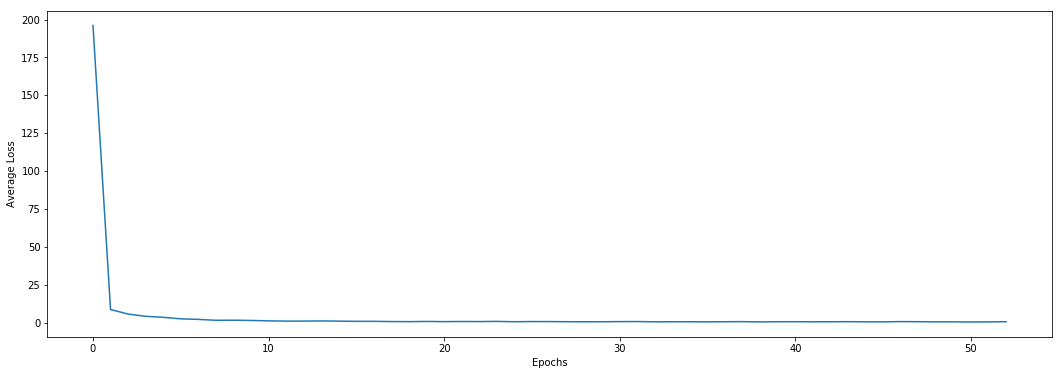

In [36]:
list_loss = np.array(avg_loss_record)
plt.figure(figsize=(18, 6))
plt.plot([i for i in range(len(list_loss))], list_loss)
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [39]:
vector = tf.placeholder(dtype=tf.float32)

#Create cosine similarity matrix

mult_vector = tf.matmul(vector, vector, transpose_b=True)
sim_matrix = tf.acos(mult_vector)

In [ ]:
with tf.Session() as sess:
    matrices = sess.run([sim_matrix, mult_vector] , feed_dict={vector:final_embeddings})

In [ ]:
sim_matrix = matrices[0]

np.fill_diagonal(sim_matrix, 0)

In [ ]:
pickle.dump(sim_matrix, open('cosine_matrix_test_domain_graph_directed_v7.pkl', 'wb'))
